# Introduction
This notebook performs customer segmentation analysis using K-Means clustering. The dataset used is a customer personality analysis dataset.

## Import Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import datetime
from mpl_toolkits.mplot3d import Axes3D

## Load Data

In [2]:
# Loading & Inspecting Data
file_path = 'marketing_campaign.csv'  # Path to the CSV file
data = pd.read_csv(file_path, sep='\t')  # Loading the data

# Display the first few rows of the data
print("First few rows of the data:")
print(data.head())

# Display the summary of the dataset
print("\nSummary of the dataset:")
print(data.info())

# Display basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())

First few rows of the data:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2 

### Observations
* 2216 non-null values in income meaning that there are some null values
* Dt_Customer is an object and not date
* Education is an object and not a string
* Martial_Status is an object and not a string

## Data Cleaning

In [5]:
# Drop rows with missing values in the Income column
data = data.dropna(subset=['Income'])

# Verify that there are no more missing values
print("Number of missing values in each column after dropping rows with missing Income:")
print(data.isnull().sum())

Number of missing values in each column after dropping rows with missing Income:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64


In [6]:
# Convert Dt_Customer to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

# Extract year and month from Dt_Customer
data['Year_Customer'] = data['Dt_Customer'].dt.year
data['Month_Customer'] = data['Dt_Customer'].dt.month

# Drop the original Dt_Customer column as we now have separate year and month columns
data = data.drop(columns=['Dt_Customer'])

# Encode categorical variables
le = LabelEncoder()
data['Education'] = le.fit_transform(data['Education'])
data['Marital_Status'] = le.fit_transform(data['Marital_Status'])

# Verify the changes
print("First few rows after preprocessing:")
print(data.head())

print("\nSummary of the dataset after preprocessing:")
print(data.info())

First few rows after preprocessing:
     ID  Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957          2               4  58138.0        0         0   
1  2174        1954          2               4  46344.0        1         1   
2  4141        1965          2               5  71613.0        0         0   
3  6182        1984          2               5  26646.0        1         0   
4  5324        1981          4               3  58293.0        1         0   

   Recency  MntWines  MntFruits  ...  AcceptedCmp4  AcceptedCmp5  \
0       58       635         88  ...             0             0   
1       38        11          1  ...             0             0   
2       26       426         49  ...             0             0   
3       26        11          4  ...             0             0   
4       94       173         43  ...             0             0   

   AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  \
0      

In [7]:
# Feature Engineering

# Calculate Customer Age
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year_Birth']

# Calculate Total Spent
data['Total_Spent'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Calculate Total Purchases
data['Total_Purchases'] = data[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Calculate Customer Tenure
data['Customer_Tenure'] = current_year - data['Year_Customer']

# Combine Kidhome and Teenhome
data['Children'] = data['Kidhome'] + data['Teenhome']

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

# Drop unnecessary columns
data = data.drop(columns=['ID', 'Marital_Status', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome', 'Year_Customer'])

# Verify the changes
print("First few rows after feature engineering:")
print(data.head())

print("\nSummary of the dataset after feature engineering:")
print(data.info())

First few rows after feature engineering:
   Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0          2  58138.0       58       635         88              546   
1          2  46344.0       38        11          1                6   
2          2  71613.0       26       426         49              127   
3          2  26646.0       26        11          4               20   
4          4  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
0              172                88            88                  3  ...   
1                2                 1             6                  2  ...   
2              111                21            42                  1  ...   
3               10                 3             5                  2  ...   
4               46                27            15                  5  ...   

   Complain  Response  Month_Customer  Age  Total_Spent 

In [8]:
print(data.describe())

         Education         Income      Recency     MntWines    MntFruits  \
count  2216.000000    2216.000000  2216.000000  2216.000000  2216.000000   
mean      2.393953   52247.251354    49.012635   305.091606    26.356047   
std       1.124141   25173.076661    28.948352   337.327920    39.793917   
min       0.000000    1730.000000     0.000000     0.000000     0.000000   
25%       2.000000   35303.000000    24.000000    24.000000     2.000000   
50%       2.000000   51381.500000    49.000000   174.500000     8.000000   
75%       3.000000   68522.000000    74.000000   505.000000    33.000000   
max       4.000000  666666.000000    99.000000  1493.000000   199.000000   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count      2216.000000      2216.000000       2216.000000   2216.000000   
mean        166.995939        37.637635         27.028881     43.965253   
std         224.283273        54.752082         41.072046     51.815414   
min           0

C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewe

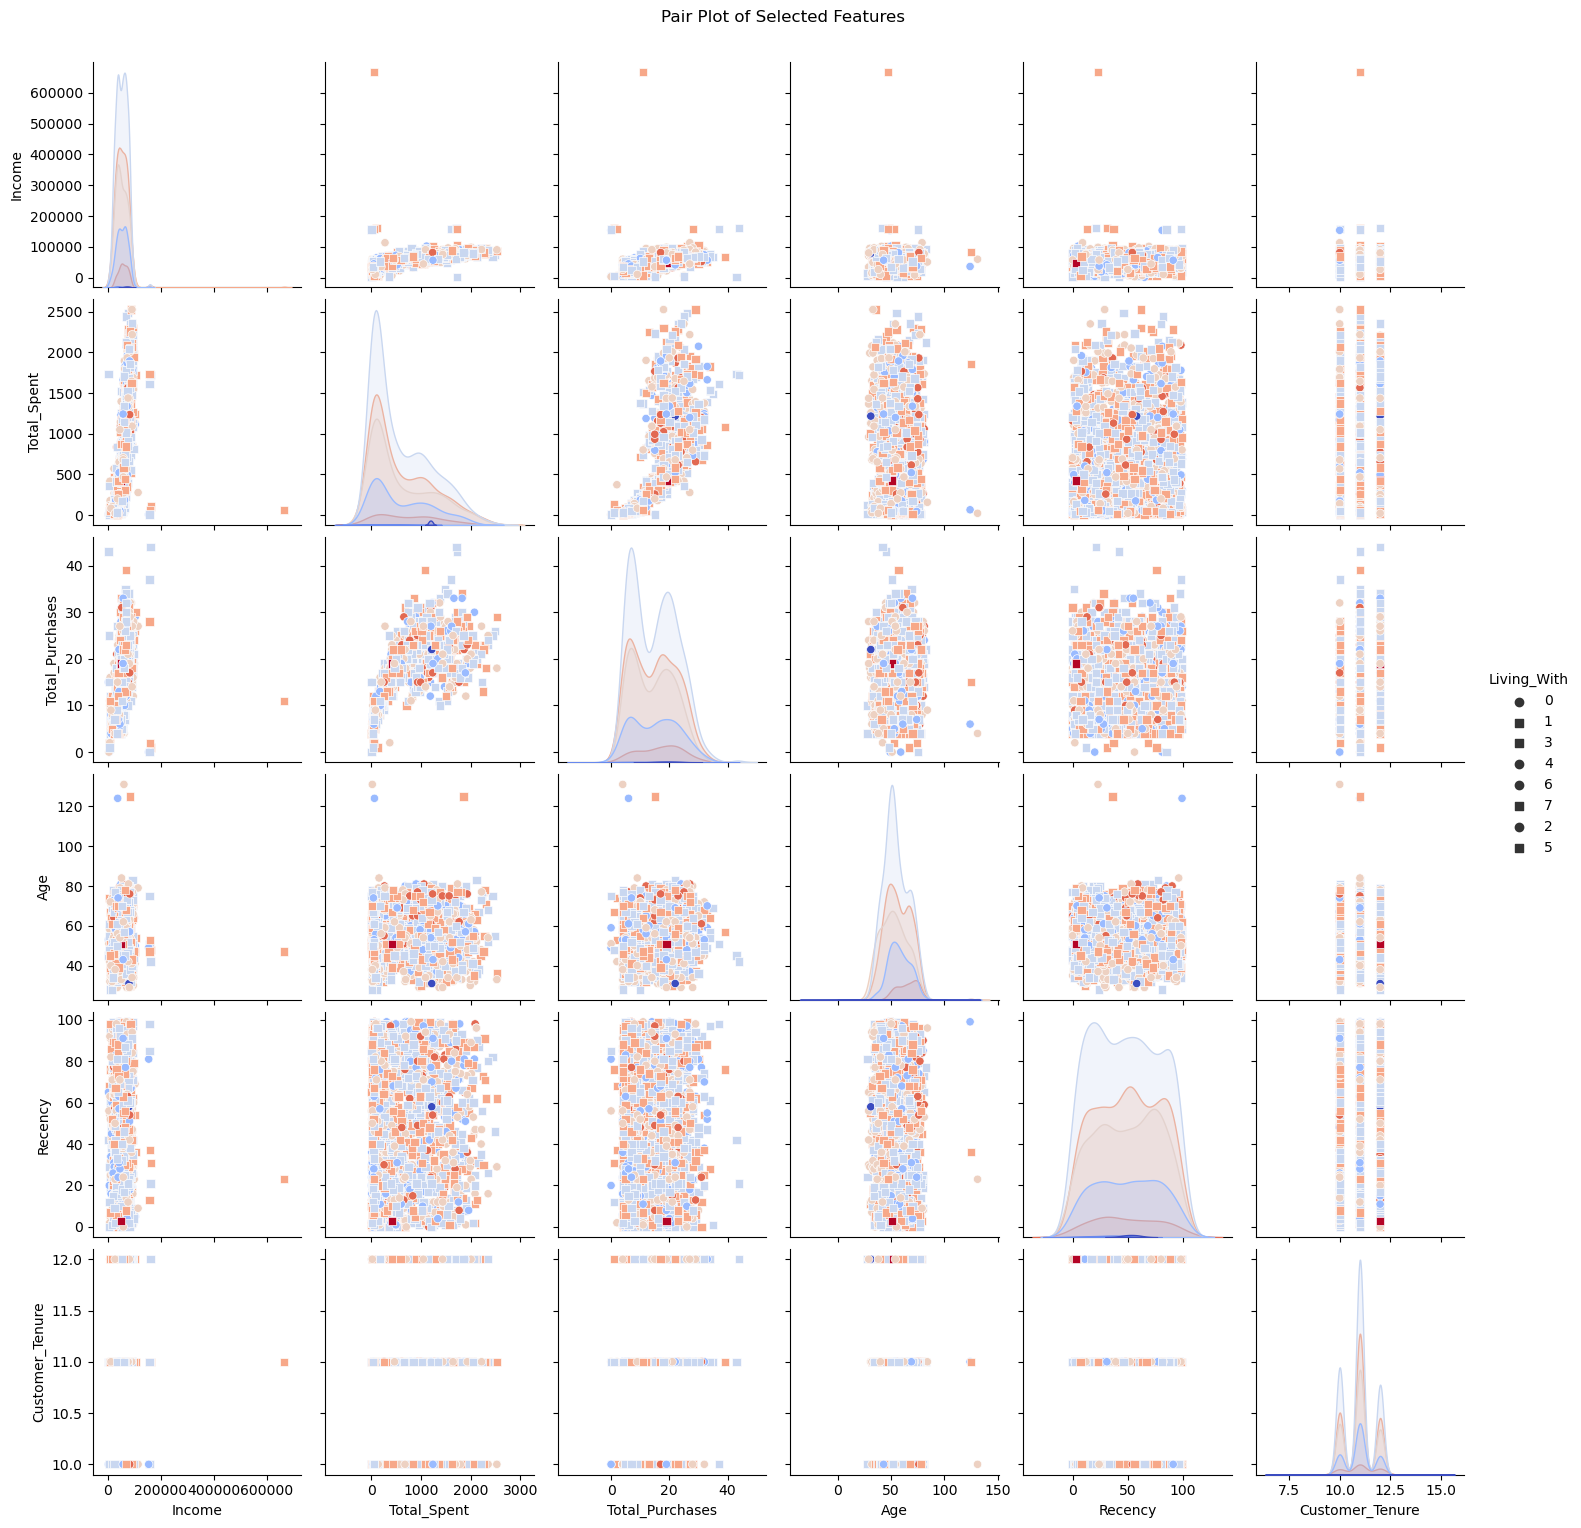

In [9]:
# Plot pair plots for selected features with hue for better distinction
sns.pairplot(data[['Income', 'Total_Spent', 'Total_Purchases', 'Age', 'Recency', 'Customer_Tenure', 'Living_With']], 
             hue='Living_With', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

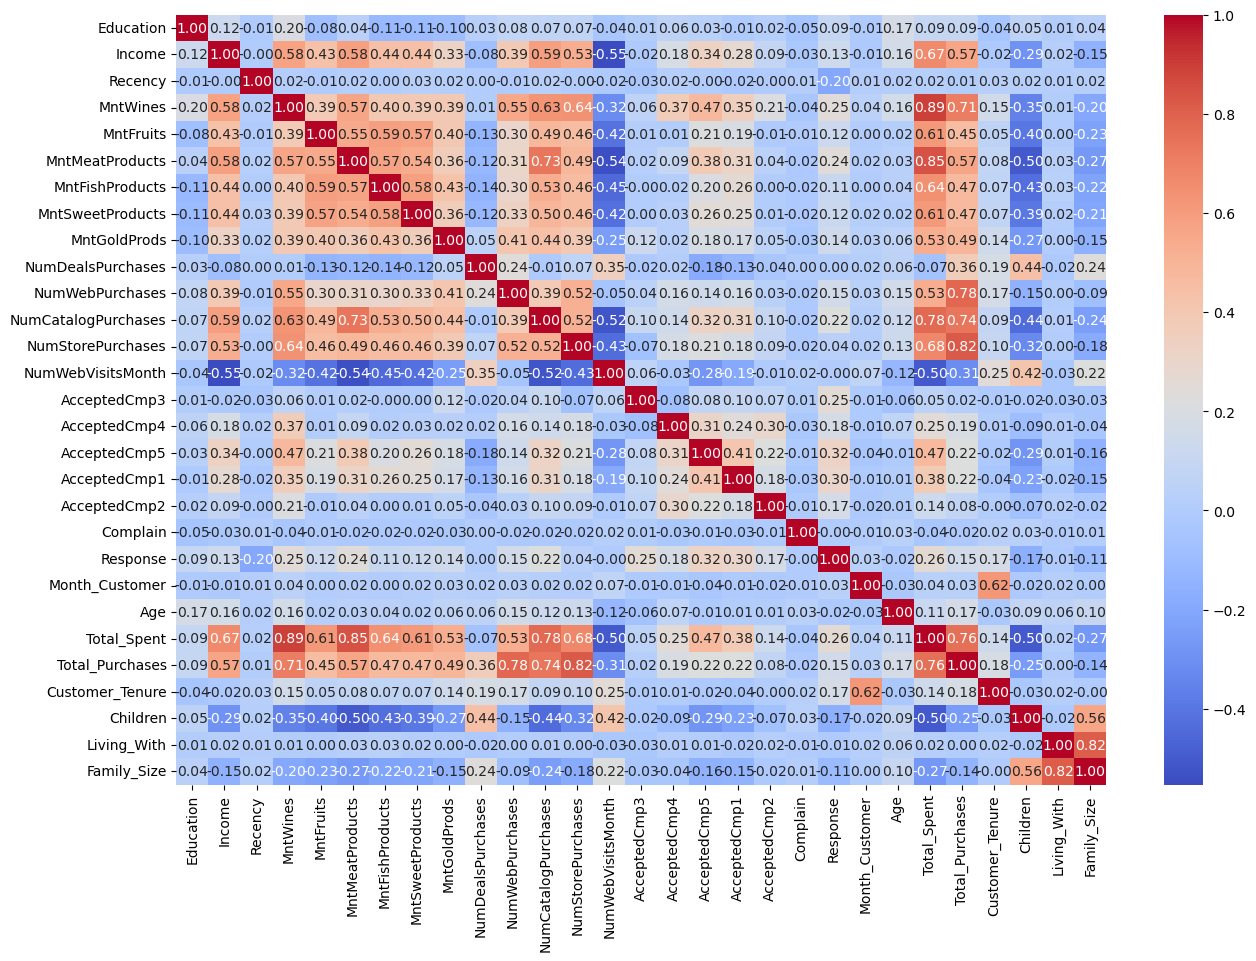

In [10]:
# Plot heatmap for correlations
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [11]:
#Dropping the outliers by setting a cap on Age and income. 
data_cleaned = data[(data["Age"]<90)]
data_cleaned = data_cleaned[(data_cleaned["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2216


C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewe

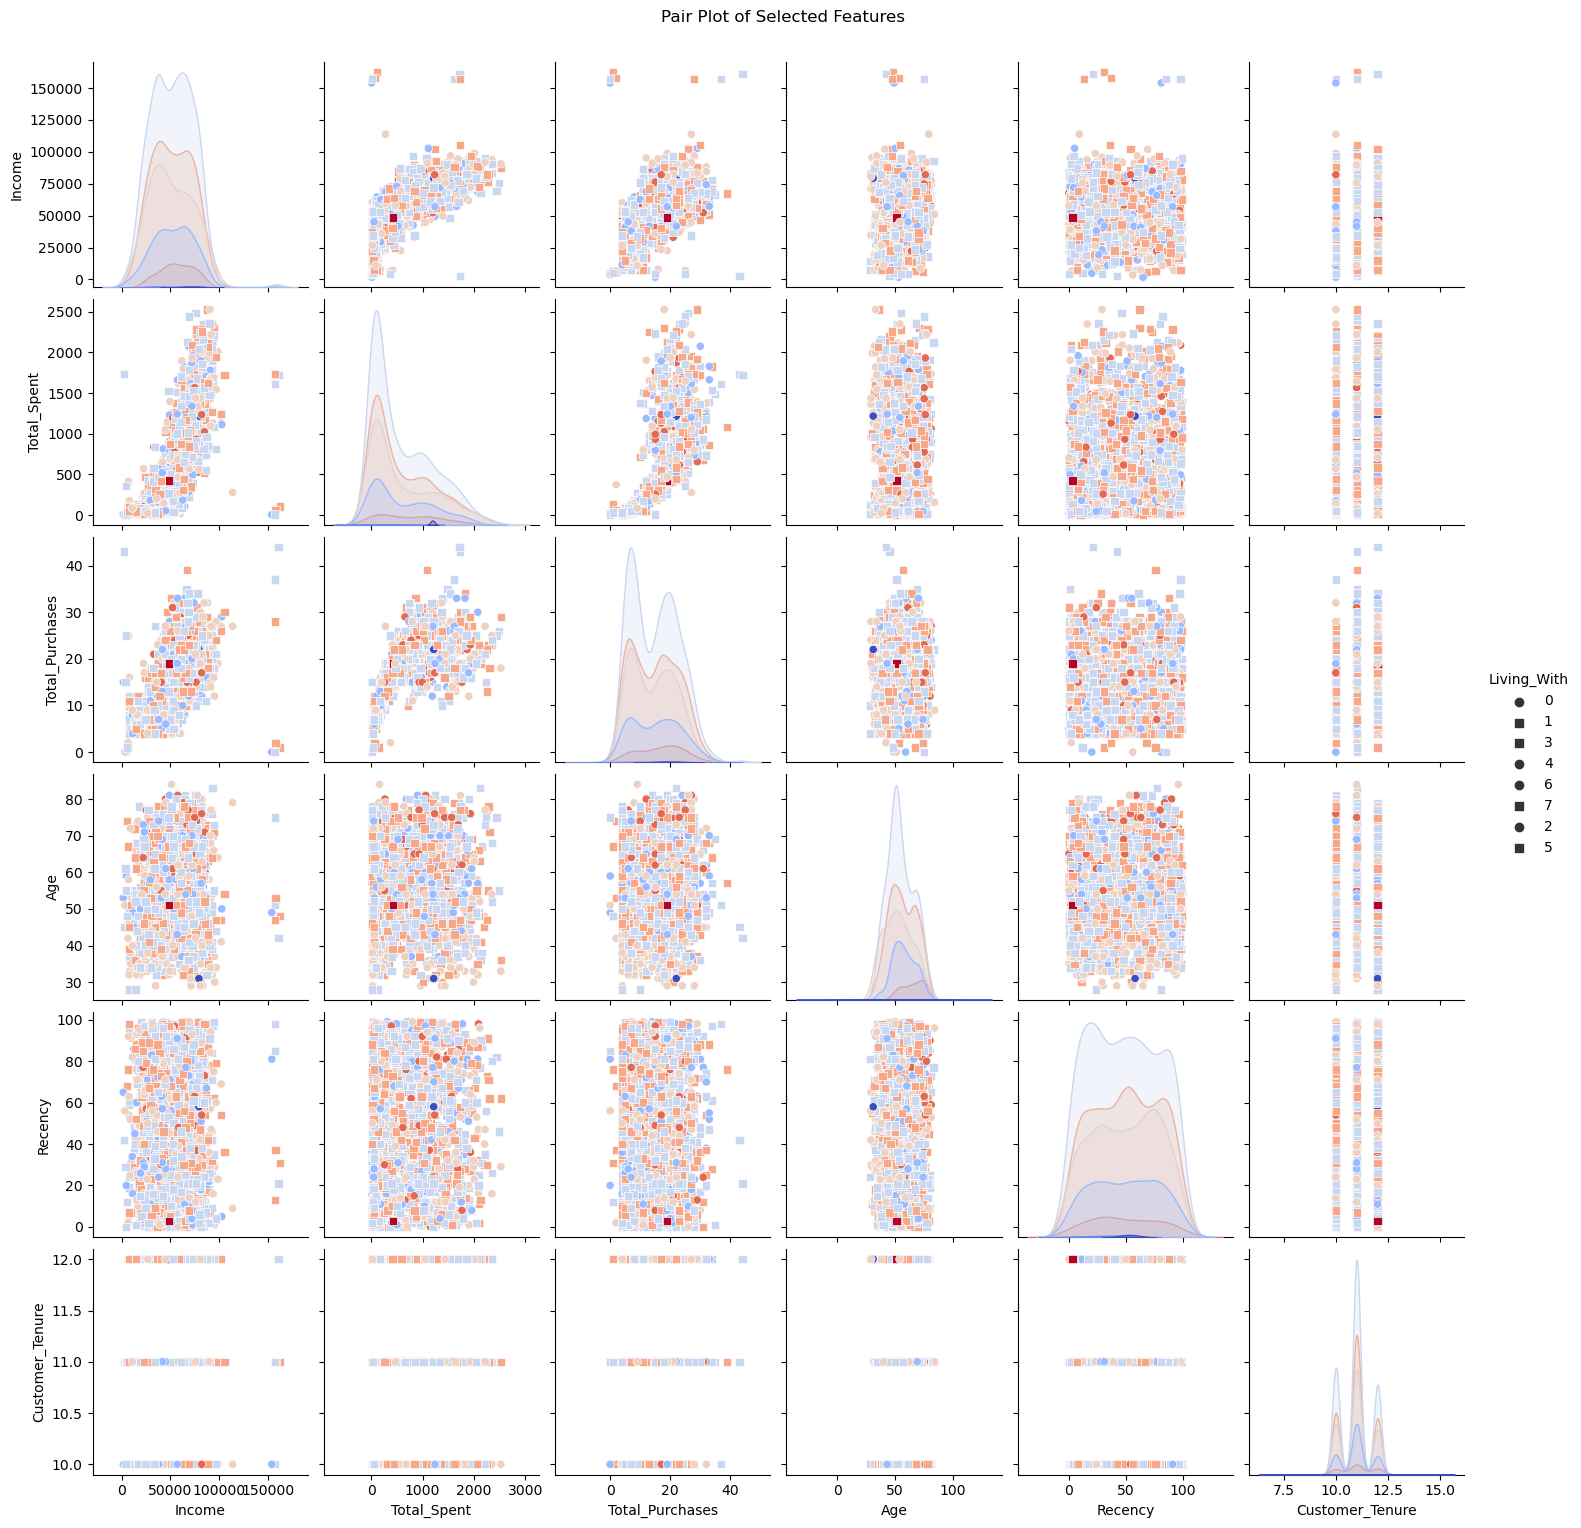

In [12]:
# Plot pair plots for selected features with hue for better distinction
sns.pairplot(data_cleaned[['Income', 'Total_Spent', 'Total_Purchases', 'Age', 'Recency', 'Customer_Tenure', 'Living_With']], 
             hue='Living_With', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

Columns after reducing multicollinearity:
Index(['Education', 'Recency', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Month_Customer', 'Age', 'Total_Spent', 'Total_Purchases',
       'Customer_Tenure', 'Children', 'Family_Size'],
      dtype='object')


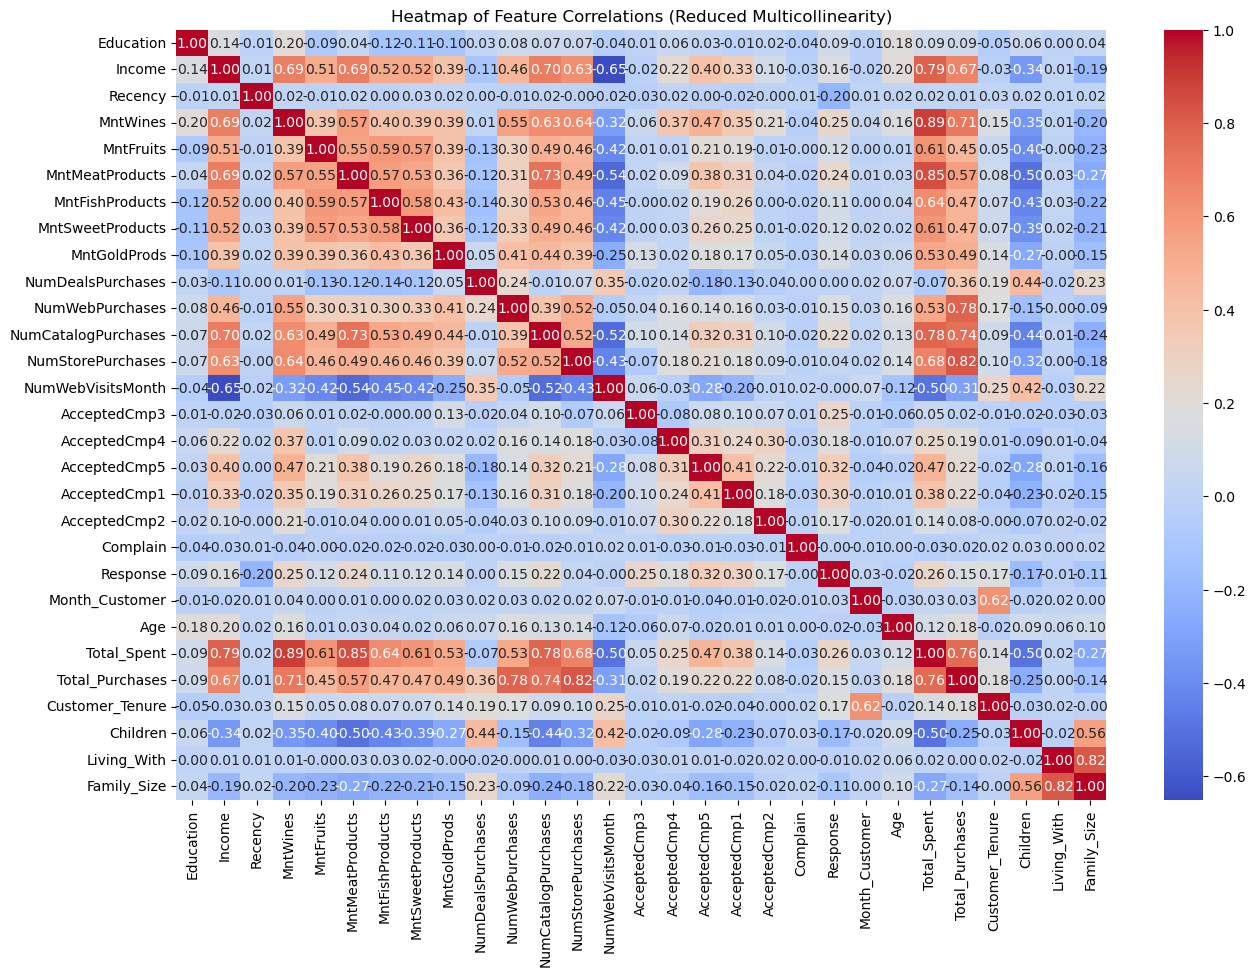

In [13]:
# Drop highly correlated features to reduce multicollinearity
data_reduced = data_cleaned.drop(columns=[
    'MntWines', 'MntFruits', 'MntMeatProducts', 'Living_With', 'NumStorePurchases', 'Income', 'NumCatalogPurchases'
])

# Verify the changes
print("Columns after reducing multicollinearity:")
print(data_reduced.columns)

data_reduced = data_cleaned
# Plot heatmap again to check for correlations after reducing multicollinearity
plt.figure(figsize=(15, 10))
sns.heatmap(data_reduced.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Feature Correlations (Reduced Multicollinearity)')
plt.show()

## Data Pre-Processing

In [14]:
# Check for missing values
missing_values = data_reduced.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Education              0
Income                 0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Month_Customer         0
Age                    0
Total_Spent            0
Total_Purchases        0
Customer_Tenure        0
Children               0
Living_With            0
Family_Size            0
dtype: int64


In [15]:
# Encoding categorical variables using LabelEncoder (already done)
# We need to scale the features
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
features = data_reduced.drop(columns=['Response'])  # Assuming 'Response' is the target variable

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Verify scaling
print("First few rows of scaled features:")
print(scaled_features[:5])

First few rows of scaled features:
[[-3.52543340e-01  2.87104872e-01  3.10353230e-01  9.77659660e-01
   1.55204051e+00  1.69029324e+00  2.45347191e+00  1.48371252e+00
   8.52575537e-01  3.51029920e-01  1.42686452e+00  2.50360729e+00
  -5.55814290e-01  6.92180521e-01 -2.82047869e-01 -2.82980786e-01
  -2.80175469e-01 -2.61914173e-01 -1.17255508e-01 -9.55200900e-02
   7.26456304e-01  1.01835202e+00  1.67624537e+00  1.31794493e+00
   1.49908579e+00 -1.26459792e+00  2.54760018e-01 -5.17223860e-01]
 [-3.52543340e-01 -2.60882029e-01 -3.80813490e-01 -8.72617990e-01
  -6.37461260e-01 -7.18229750e-01 -6.51003677e-01 -6.34018624e-01
  -7.33642421e-01 -1.68701126e-01 -1.12641992e+00 -5.71339588e-01
  -1.17116024e+00 -1.32545206e-01 -2.82047869e-01 -2.82980786e-01
  -2.80175469e-01 -2.61914173e-01 -1.17255508e-01 -9.55200900e-02
  -9.92176150e-01  1.27478522e+00 -9.63296959e-01 -1.15927285e+00
  -1.41734145e+00  1.40457250e+00  2.54760018e-01  1.01951110e+00]
 [-3.52543340e-01  9.13196401e-01 -7.95

## Dimensionality Reduction

First few rows with PCA features added:
   Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0          2  58138.0       58       635         88              546   
1          2  46344.0       38        11          1                6   
2          2  71613.0       26       426         49              127   
3          2  26646.0       26        11          4               20   
4          4  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
0              172                88            88                  3  ...   
1                2                 1             6                  2  ...   
2              111                21            42                  1  ...   
3               10                 3             5                  2  ...   
4               46                27            15                  5  ...   

   Month_Customer  Age  Total_Spent  Total_Purchases  Cust

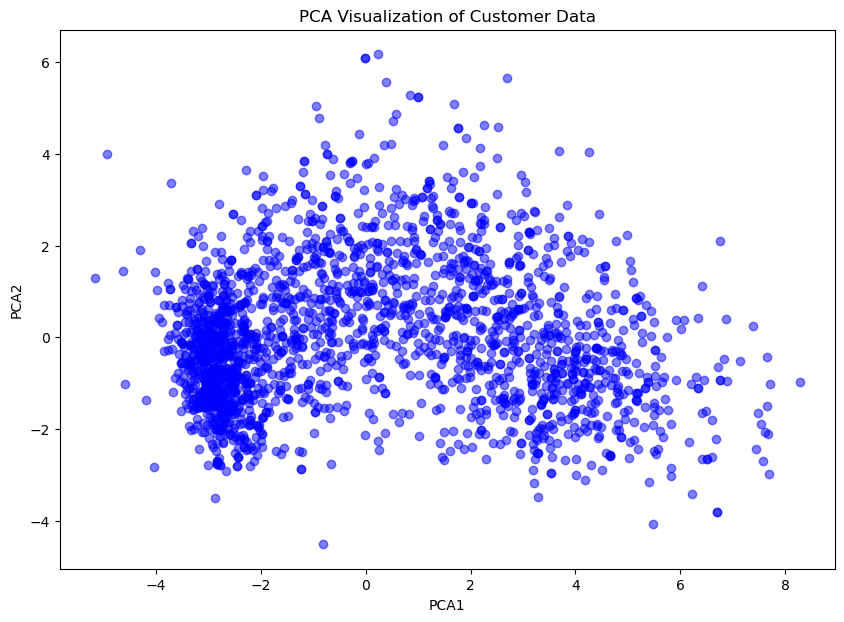

In [16]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=10)
pca_features = pca.fit_transform(scaled_features)

# Add PCA features to the original data for visualization purposes
data_reduced['PCA1'] = pca_features[:, 0]
data_reduced['PCA2'] = pca_features[:, 1]

# Verify the changes
print("First few rows with PCA features added:")
print(data_reduced.head())

# Visualize the PCA features with distinct colors
plt.figure(figsize=(10, 7))
plt.scatter(data_reduced['PCA1'], data_reduced['PCA2'], c='blue', alpha=0.5)
plt.title('PCA Visualization of Customer Data')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [17]:
# Check the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each principal component:")
print(explained_variance)

# Sum of explained variance for the first two components
total_explained_variance = float(0)
for i in explained_variance:
    total_explained_variance += i
print(f"Total explained variance by the first two components: {total_explained_variance:.2f}")

Explained variance by each principal component:
[0.29306334 0.08542851 0.06621902 0.06195751 0.05533596 0.04468386
 0.03871493 0.03595615 0.03540749 0.03067559]
Total explained variance by the first two components: 0.75


## Clustering

C:\Users\mosae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mosae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mosae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mosae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

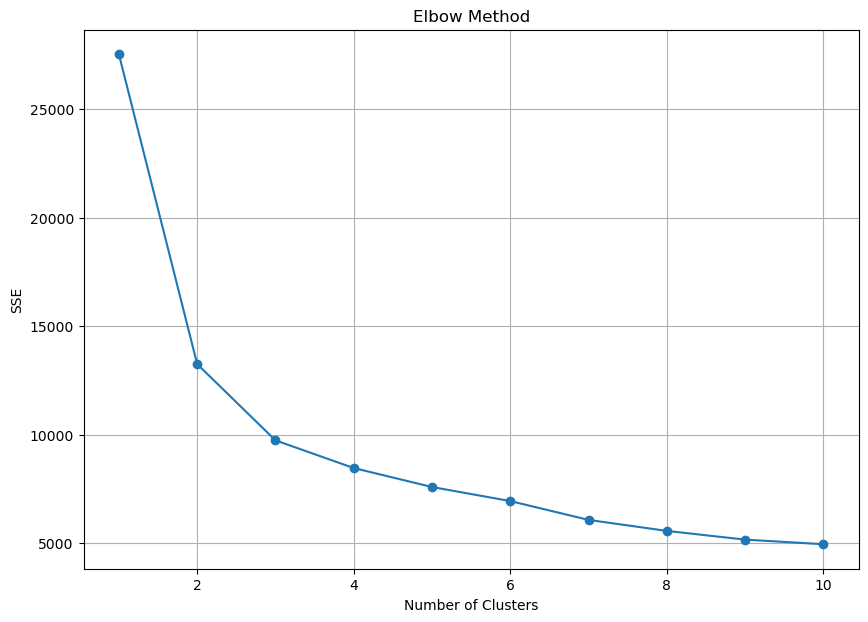

In [27]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    sse.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

C:\Users\mosae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Silhouette Score: 0.4615356551495189


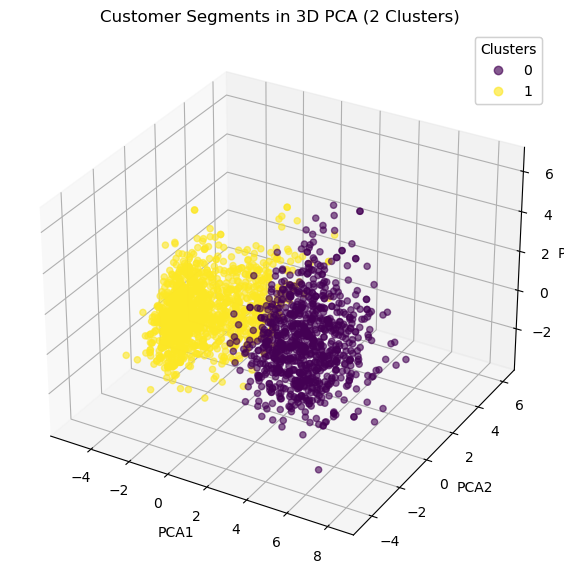

In [19]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

# Perform K-Means clustering with 2 clusters
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_features)
data_reduced['Cluster'] = clusters

# Evaluate the clustering
score = silhouette_score(pca_features, clusters)
print(f'Silhouette Score: {score}')

# Visualize the clusters in 3D with 2 clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=clusters, cmap='viridis', alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('Customer Segments in 3D PCA (2 Clusters)')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

In [20]:
# Calculate mean values for each cluster
cluster_summary = data_reduced.groupby('Cluster').mean()
print("Summary statistics for each cluster:")
print(cluster_summary)

Summary statistics for each cluster:
         Education        Income    Recency    MntWines  MntFruits  \
Cluster                                                              
0         2.464126  71330.119955  49.478700  612.266816  55.275785   
1         2.349242  38868.501515  48.709091   97.843939   6.768939   

         MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
Cluster                                                                     
0             360.288117        78.618834         57.228700     75.697309   
1              36.434091         9.962879          6.650758     22.456061   

         NumDealsPurchases  ...  Month_Customer        Age  Total_Spent  \
Cluster                     ...                                           
0                 2.094170  ...        6.526906  56.938341  1239.375561   
1                 2.480303  ...        6.421212  53.834848   180.116667   

         Total_Purchases  Customer_Tenure  Children  Living_With  Family

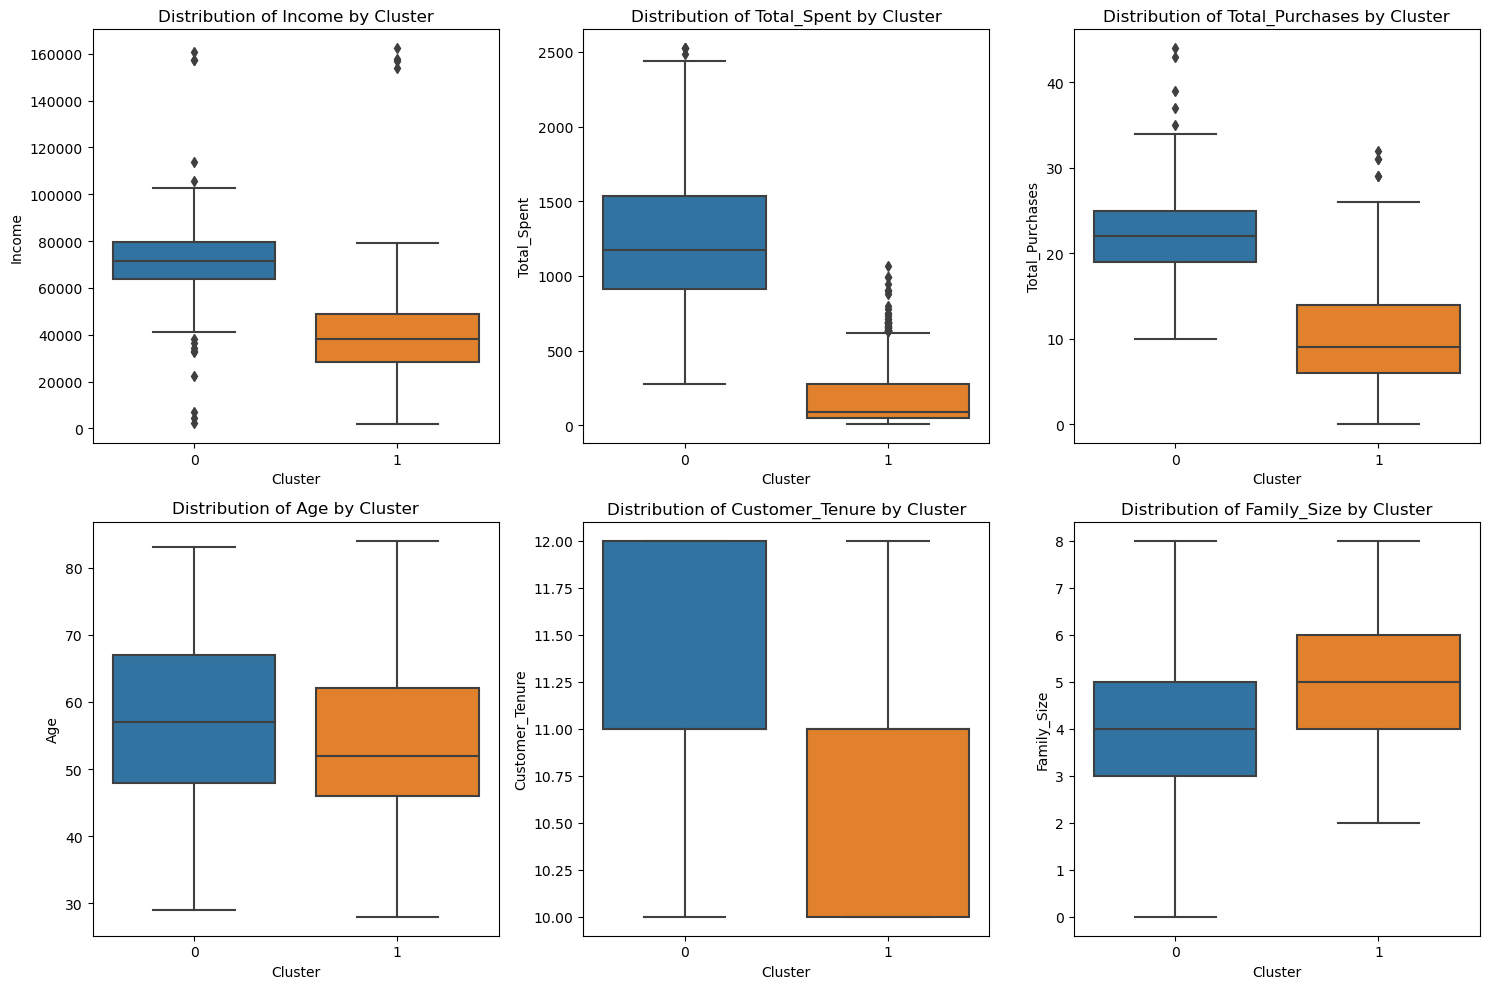

In [42]:
# Select key features to visualize
key_features = ['Income', 'Total_Spent', 'Total_Purchases', 'Age', 'Customer_Tenure', 'Family_Size']

# Plot box plots for key features by cluster
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=data_reduced)
    plt.title(f'Distribution of {feature} by Cluster')
plt.tight_layout()
plt.show()

C:\Users\mosae\AppData\Local\Temp\ipykernel_12412\2727707907.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Cluster', y=feature, data=data_reduced, palette='viridis')
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 47.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 53.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mosae\AppData\Local\Temp\ipykernel_12412\2727707907.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Cluster', y=feature, data=data_reduced, palette='viridis')
C:\Users\mosae\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 67.0% of the points cannot be pla

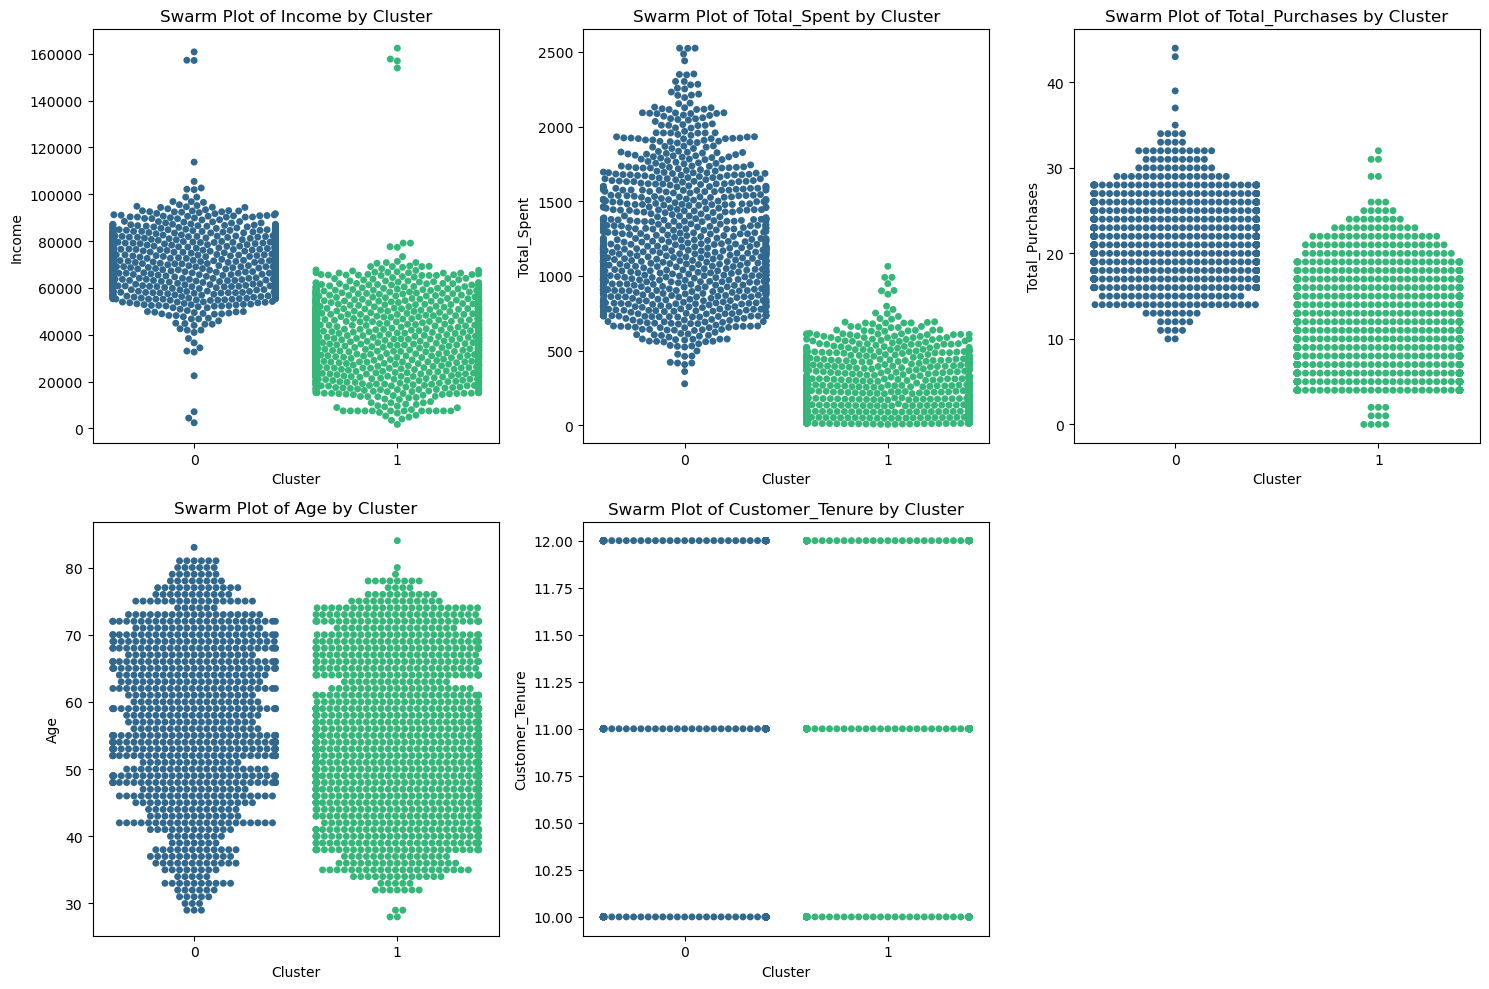

In [38]:
# Swarm plot for key features by cluster
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.swarmplot(x='Cluster', y=feature, data=data_reduced, palette='viridis')
    plt.title(f'Swarm Plot of {feature} by Cluster')
plt.tight_layout()
plt.show()

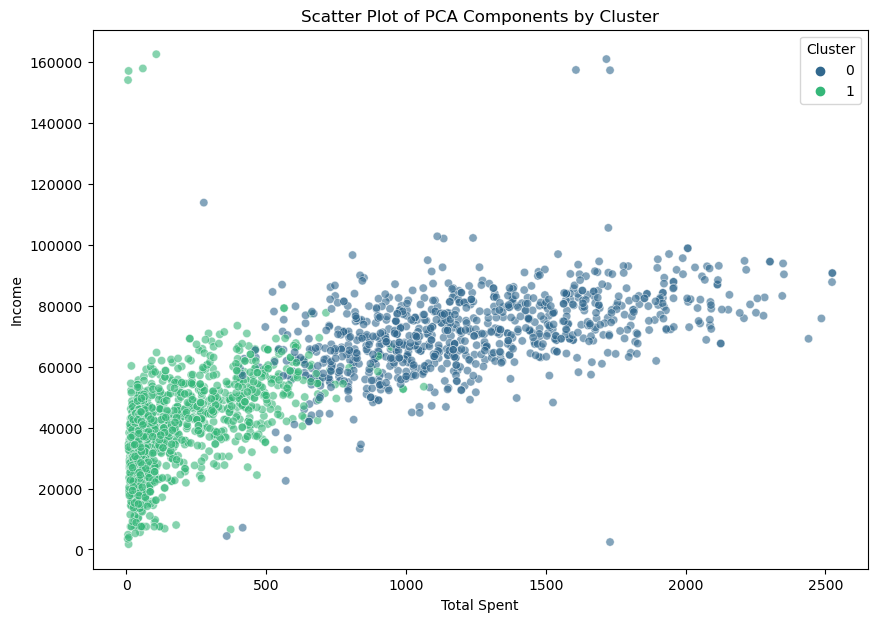

In [41]:
# Scatter plot for PCA components colored by cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Total_Spent', y='Income', hue='Cluster', data=data_reduced, palette='viridis', alpha=0.6)
plt.title('Scatter Plot of PCA Components by Cluster')
plt.xlabel('Total Spent')
plt.ylabel('Income')
plt.legend(title='Cluster')
plt.show()

## Profiling

### Cluster 0: 

High-Spending Older Customers

**Characteristics:** Higher income, higher total spent, more purchases, older age, longer customer tenure, and less family members.

**Potential Strategy:** Focus on premium products, loyalty programs, and personalized offers to retain these high-value customers.


### Cluster 1: Lower-Spending Younger Customers

**Characteristics:** Lower income, lower total spent, fewer purchases, younger age, shorter customer tenure, and more family members.

**Potential Strategy:** Focus on value-for-money products, discounts, and promotional campaigns to increase engagement and spending.
